In [13]:
# %% [markdown]
# # EfficientNet-B0/B1/B2 Fine-tuning on Food-11 Dataset
# ### Kaggle / Colab Compatible
# - Multiclass classification (11 classes)
# - Visualization of accuracy/loss
# - EfficientNet-B0, B1, B2 pretrained on ImageNet

# %%
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [14]:

# %% [markdown]
# ## 1. Configuration

# %%
writer = SummaryWriter(log_dir='runs/food11_effnet')
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = 11
num_epochs = 10
batch_size = 32
val_split = 0.2
models_to_train = ['b0', 'b1', 'b2']

Using device: cpu


In [15]:

# %% [markdown]
# ## 2. Dataset & Data Loaders

# %%
def get_transforms(input_size: int):
    train_tf = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_tf = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_tf, val_tf

# Укажите пути к данным Kaggle/Colab (измените при необходимости)
train_dir = 'food11/train'  # локальный путь
test_dir = 'food11/test'

In [16]:

# %% [markdown]
# ## 3. EfficientNet Model Factory

# %%
def get_effnet(model_name: str, num_classes: int):
    if model_name == 'b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        input_size = 224
    elif model_name == 'b1':
        model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
        input_size = 240
    elif model_name == 'b2':
        model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        input_size = 260
    else:
        raise ValueError("Unsupported model name")
    
    # Заморозим все слои сначала
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Разморозим только последние 2 блока
    for i in range(7, 8):
        for param in model.features[i].parameters():
            param.requires_grad = True

    
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model, input_size

In [17]:

# %% [markdown]
# ## 4. Training & Evaluation Functions

# %%
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # --- прогресс по батчам ---
        if i % 10 == 0 or i == len(dataloader)-1:  # каждые 10 батчей и последний
            print(f"Batch [{i+1}/{len(dataloader)}] -> Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item(), all_labels, all_preds



===== Training EfficientNet-B0 =====
Training on cpu
Train size: 7920, Val size: 1980
Number of batches: 248
Batch [1/248] -> Loss: 2.4350
Batch [11/248] -> Loss: 3.9691
Batch [21/248] -> Loss: 4.1726
Batch [31/248] -> Loss: 3.4037
Batch [41/248] -> Loss: 2.4167
Batch [51/248] -> Loss: 3.6399
Batch [61/248] -> Loss: 1.7886
Batch [71/248] -> Loss: 1.2790
Batch [81/248] -> Loss: 1.1587
Batch [91/248] -> Loss: 1.2960
Batch [101/248] -> Loss: 1.6749
Batch [111/248] -> Loss: 1.3844
Batch [121/248] -> Loss: 1.4001
Batch [131/248] -> Loss: 1.0805
Batch [141/248] -> Loss: 1.0338
Batch [151/248] -> Loss: 1.9046
Batch [161/248] -> Loss: 1.3011
Batch [171/248] -> Loss: 1.6578
Batch [181/248] -> Loss: 0.8418
Batch [191/248] -> Loss: 1.3455
Batch [201/248] -> Loss: 0.6621
Batch [211/248] -> Loss: 1.8029
Batch [221/248] -> Loss: 1.0070
Batch [231/248] -> Loss: 1.7539
Batch [241/248] -> Loss: 0.9283
Batch [248/248] -> Loss: 1.2743
Epoch [1/10] -> Train acc: 0.595, Val acc: 0.734
Training on cpu
Trai

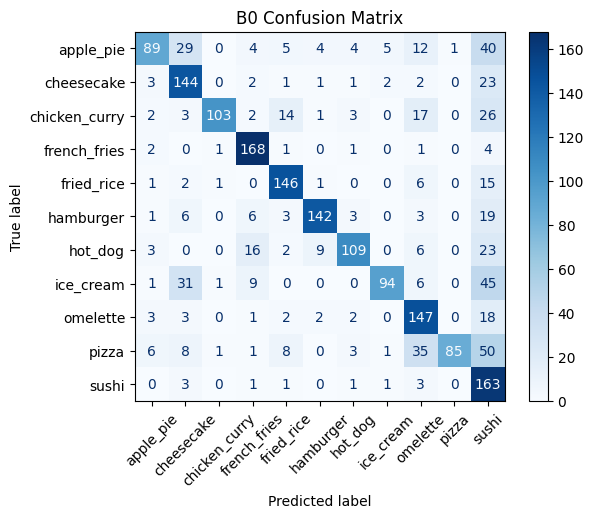


===== Training EfficientNet-B1 =====
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /Users/nikitaradcenko/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth


100.0%


Training on cpu
Train size: 7920, Val size: 1980
Number of batches: 248
Batch [1/248] -> Loss: 2.3454
Batch [11/248] -> Loss: 4.6251
Batch [21/248] -> Loss: 6.3299
Batch [31/248] -> Loss: 4.4604
Batch [41/248] -> Loss: 2.4092
Batch [51/248] -> Loss: 3.7835
Batch [61/248] -> Loss: 1.9982
Batch [71/248] -> Loss: 1.2315
Batch [81/248] -> Loss: 2.5185
Batch [91/248] -> Loss: 1.7849
Batch [101/248] -> Loss: 1.9438
Batch [111/248] -> Loss: 1.2189
Batch [121/248] -> Loss: 1.1629
Batch [131/248] -> Loss: 1.3724
Batch [141/248] -> Loss: 1.1680
Batch [151/248] -> Loss: 1.2097
Batch [161/248] -> Loss: 1.0877
Batch [171/248] -> Loss: 0.8297
Batch [181/248] -> Loss: 2.1151
Batch [191/248] -> Loss: 1.0531
Batch [201/248] -> Loss: 0.7420
Batch [211/248] -> Loss: 0.8356
Batch [221/248] -> Loss: 1.1011
Batch [231/248] -> Loss: 1.3743
Batch [241/248] -> Loss: 1.4165
Batch [248/248] -> Loss: 1.8864
Epoch [1/10] -> Train acc: 0.591, Val acc: 0.654
Training on cpu
Train size: 7920, Val size: 1980
Number of

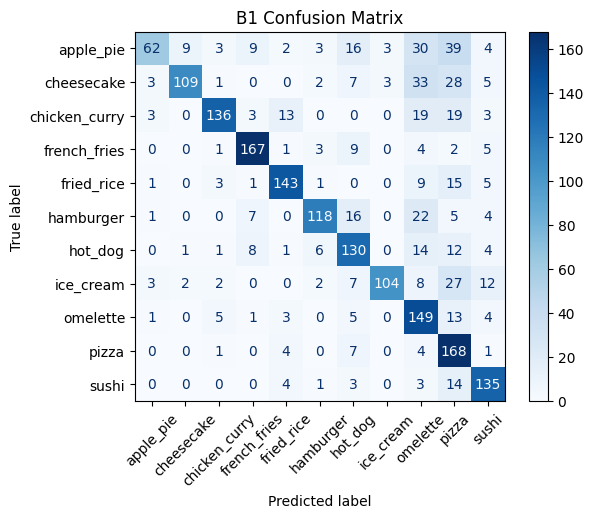


===== Training EfficientNet-B2 =====
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/nikitaradcenko/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100.0%


Training on cpu
Train size: 7920, Val size: 1980
Number of batches: 248
Batch [1/248] -> Loss: 2.4108
Batch [11/248] -> Loss: 3.3042
Batch [21/248] -> Loss: 4.5023
Batch [31/248] -> Loss: 2.3967
Batch [41/248] -> Loss: 3.8011
Batch [51/248] -> Loss: 1.3585
Batch [61/248] -> Loss: 3.8695
Batch [71/248] -> Loss: 2.1086
Batch [81/248] -> Loss: 1.0168
Batch [91/248] -> Loss: 1.5396
Batch [101/248] -> Loss: 1.7850
Batch [111/248] -> Loss: 1.1836
Batch [121/248] -> Loss: 1.1572
Batch [131/248] -> Loss: 0.7199
Batch [141/248] -> Loss: 1.2367
Batch [151/248] -> Loss: 0.4505
Batch [161/248] -> Loss: 0.5796
Batch [171/248] -> Loss: 0.7100
Batch [181/248] -> Loss: 1.1468
Batch [191/248] -> Loss: 0.9794
Batch [201/248] -> Loss: 0.9733
Batch [211/248] -> Loss: 0.7962
Batch [221/248] -> Loss: 1.2583
Batch [231/248] -> Loss: 0.5424
Batch [241/248] -> Loss: 0.6412
Batch [248/248] -> Loss: 1.3089
Epoch [1/10] -> Train acc: 0.655, Val acc: 0.778
Training on cpu
Train size: 7920, Val size: 1980
Number of

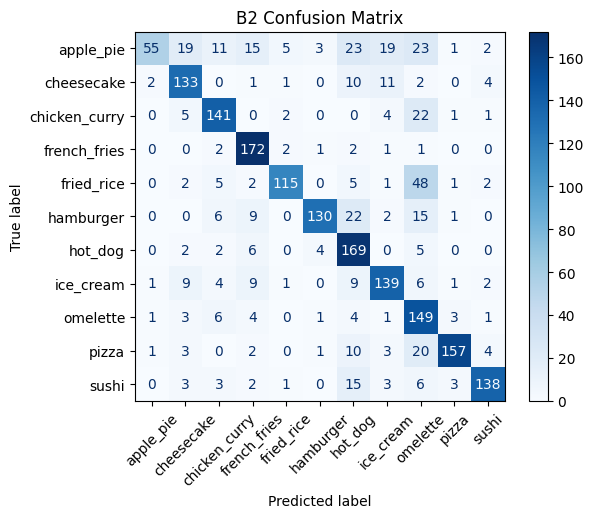

In [18]:

# %% [markdown]
# ## 5. Training Loop for B0, B1, B2

# %%
results = {}

for model_name in models_to_train:
    print(f"\n===== Training EfficientNet-{model_name.upper()} =====")

    model, input_size = get_effnet(model_name, num_classes)
    model = model.to(device)

    train_tf, val_tf = get_transforms(input_size)

    # --- Dataset split ---
    full_train_dataset = datasets.ImageFolder(train_dir)
    indices = list(range(len(full_train_dataset)))
    np.random.shuffle(indices)
    split = int(val_split * len(full_train_dataset))
    train_idx, val_idx = indices[split:], indices[:split]

    train_dataset = Subset(datasets.ImageFolder(train_dir, transform=train_tf), train_idx)
    val_dataset = Subset(datasets.ImageFolder(train_dir, transform=val_tf), val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-5)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
     
    for epoch in range(num_epochs):
        
        print(f"Training on {device}")
        print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
        print(f"Number of batches: {len(train_loader)}")

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        v_loss, v_acc, val_labels, val_preds = evaluate(model, val_loader, criterion)

        train_losses.append(tr_loss)
        val_losses.append(v_loss)
        train_accs.append(tr_acc)
        val_accs.append(v_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] -> Train acc: {tr_acc:.3f}, Val acc: {v_acc:.3f}")

        # --- TensorBoard logging ---
        writer.add_scalar(f'{model_name}/Train_Loss', tr_loss, epoch)
        writer.add_scalar(f'{model_name}/Val_Loss', v_loss, epoch)
        writer.add_scalar(f'{model_name}/Train_Acc', tr_acc, epoch)
        writer.add_scalar(f'{model_name}/Val_Acc', v_acc, epoch)

    # --- Confusion Matrix & F1-score ---
    cm = confusion_matrix(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"{model_name.upper()} F1-score (macro) on val set: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=full_train_dataset.classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"{model_name.upper()} Confusion Matrix")
    plt.show()

    results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'f1_score': f1
    }

writer.close()
  

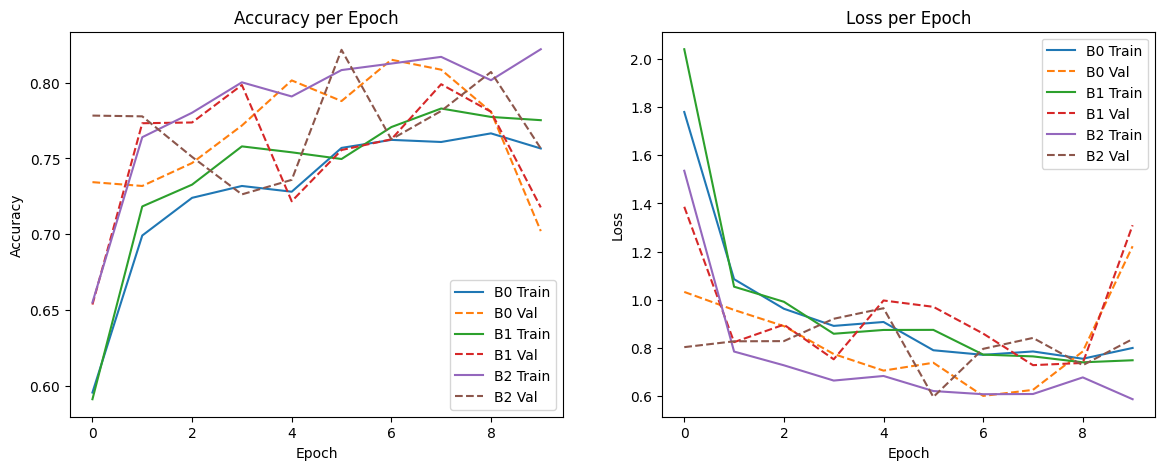

In [19]:

# %% [markdown]
# ## 6. Visualization

# %%
fig, axs = plt.subplots(1, 2, figsize=(14,5))

for m in results.keys():
    axs[0].plot(results[m]['train_accs'], label=f'{m.upper()} Train')
    axs[0].plot(results[m]['val_accs'], '--', label=f'{m.upper()} Val')
axs[0].set_title('Accuracy per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

for m in results.keys():
    axs[1].plot(results[m]['train_losses'], label=f'{m.upper()} Train')
    axs[1].plot(results[m]['val_losses'], '--', label=f'{m.upper()} Val')
axs[1].set_title('Loss per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

# %% [markdown]
# ✅ Готово! После выполнения ноутбука вы получите:
# - Обучение EfficientNet-B0/B1/B2 по 10 эпох.
# - Графики точности и потерь.
# - Можно запускать на Kaggle или Colab (GPU поддерживается).
